<a href="https://colab.research.google.com/github/helmieresearch/helmieresearch/blob/main/Momentum_Ranking_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install packages

In [39]:
!pip install yfinance

In [40]:
!pip install yahooquery

In [41]:
!pip install stockstats

In [42]:
!pip install mpld3

###Import data

In [43]:
%matplotlib inline
import datetime
from datetime import date
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import mpld3
mpld3.enable_notebook()
"""
Settings
"""
portfolio_value = 2000.00
perf_last_month = 2000.00
start = "2020-01-01"
end = "2023-08-19"
ranking_day = "2023-08-16"

# Storing today's date into a variable
today = date.today()
# Storing the specific date
trading_day = today
# Calculate percent difference since last month
perf_pct = (portfolio_value / perf_last_month) - 1
# Print performance, format as percent with two decimals.
print("{} - Last Month Result: {:.2%}".format(trading_day, perf_pct))
# Remember today's portfolio value for next month's calculation
#perf_last_month = portfolio_value

2023-08-16 - Last Month Result: 0.00%


In [47]:

now = datetime.datetime.now().strftime("%Y-%m-%d")
data = yf.Ticker("STXCAP.JO")
index = data.history(start=start,  end=end)
resetindex = index.reset_index(inplace = True)

index['Date'] = pd.to_datetime(index['Date']).dt.strftime('%Y-%m-%d')

index = index.drop(columns=(['Open', 'High','Low','Volume','Dividends','Stock Splits']))

index.set_index("Date", inplace=True)

index.to_csv('STXCAP160823.csv')

<Axes: >

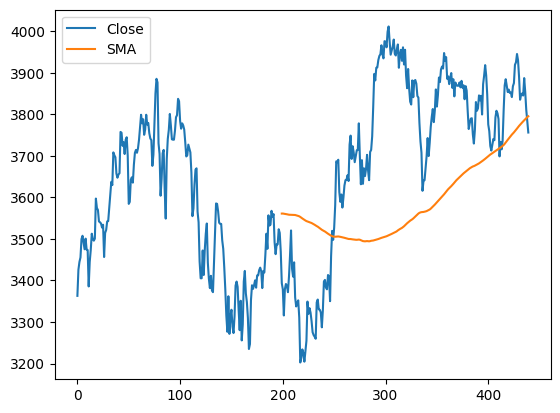

In [49]:
STX = pd.read_csv("STXCAP160823.csv")
STX['SMA'] = STX['Close'].rolling(200).mean()
STX.plot()

In [51]:
STX.tail()

,Date,Close,SMA
435,2023-08-10,3887.0,3785.437803
436,2023-08-11,3854.0,3788.060654
437,2023-08-14,3811.0,3790.502942
438,2023-08-15,3783.0,3792.982327
439,2023-08-16,3756.0,3795.115178


In [ ]:
#Import required libraries
import pandas as pd
import json
import requests
import glob
import os
from yahooquery import Ticker
from datetime import datetime

params = {'access_key': 'e52cf3b93696352e880916f8c8adbf0c',
          'limit': 350}
api_result = requests.get('http://api.marketstack.com/v1/exchanges/XJSE/tickers', params)
api_response = api_result.json()
print(f"Exchange Name = {api_response['data']['name']}")
for ticker in api_response['data']['tickers']:
  print(f"{ticker['name']}: {ticker['symbol']}")


# Serializing json
json_object = json.dumps(api_response, indent=4)
# Writing to sample.json
with open("jse.json", "w") as outfile:
    outfile.write(json_object)

# Opening JSON file
with open('jse.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
df1 = pd.json_normalize(json_object["data"]["tickers"])

# dropping null value columns to avoid errors
# new data frame with split value columns
new = df1["symbol"].str.split(".", n = 1, expand = True)
# making separate first name column from new data frame
df1["ticker"]= new[0]
# Dropping old Name columns
df1.drop(columns =["has_intraday","has_eod"], inplace = True)
new.columns = new.columns.astype(str)
new.columns.values[1] = "tickers"
new['0'] + '.' + new['tickers']
new.replace("XJSE", "JO", inplace=True)

result = pd.concat([df1, new], axis=1, join='inner')
df2=result['0'] + '.' + result['tickers']
final = pd.concat([df1, df2], axis=1, join='inner')
final.columns.values[3] = "tickers"
final.columns = final.columns.astype(str)
#Dropping old Name columns
final.drop(columns =["name", "symbol","ticker"], inplace = True)
# Converting a specific Dataframe
# column to list using Series.tolist()
xjse = final["tickers"].tolist()
print("Converting tickers to list...")
print("Output dataframe..." )
print("Writing csv file..." )
print("Saving JSE data to disc...")
print("Saving csv files for each stock to disc...")
symbols = xjse
tickers = Ticker(symbols, asynchronous=True)
data = tickers.history(start= start, end=end, interval='1d')
data= data.drop(['adjclose','dividends','splits'],axis=1)


#Convert dataframe to csv and save to disc
final.to_csv("tickers.csv")
data.to_csv("jse_stocks.csv")

resetindex = data.reset_index(inplace = True)

for i, g in data.groupby('symbol'):
    g.to_csv('/content/Stocks/{}.csv'.format(i), header=True, index_label=False)

# merging the files
joined_files = os.path.join("/content/Stocks/", "*.csv")

# A list of all joined files is returned
joined_list = glob.glob(joined_files)

# Finally, the files are joined
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)

# new dataframe with different column order
df_new = df.iloc[:, [1, 2, 3, 4, 5, 6, 0]]

Tickers = df_new["symbol"].tolist()
mylist = list(dict.fromkeys(Tickers))
df = pd.DataFrame (mylist, columns = ['tickers'])
df.to_csv("/content/tickers.csv")

#Change date format to Year-Month-Day
df_new['date'] =  pd.to_datetime(df_new['date']).dt.strftime('%Y-%m-%d')

df_new.set_index('date', inplace=True)

for i, g in df_new.groupby('symbol'):
    g.to_csv('/content/Stocks_final3/{}.csv'.format(i), header=True, index_label=False)

Exchange Name = Johannesburg Stock Exchange
PROSUS N.V.: PRX.XJSE
ANHEUSER-BUSCH INBEV SA NV: ANH.XJSE
BHP GROUP PLC: BHP.XJSE
BRITISH AMERICAN TOB PLC: BTI.XJSE
NASPERS LTD -N-: NPN.XJSE
COMPAGNIE FIN RICHEMONT: CFR.XJSE
GLENCORE PLC: GLN.XJSE
ANGLO AMERICAN PLC: AGL.XJSE
FIRSTRAND LTD: FSR.XJSE
ANGLO AMERICAN PLAT LTD: AMS.XJSE
STANDARD BANK GROUP LTD: SBK.XJSE
VODACOM GROUP LTD: VOD.XJSE
MONDI PLC: MNP.XJSE
CAPITEC BANK HLDGS LTD: CPI.XJSE
BEE - SASOL LIMITED: SOLBE1.XJSE
SANLAM LIMITED: SLM.XJSE
MTN GROUP LTD: MTN.XJSE
ANGLOGOLD ASHANTI LTD: ANG.XJSE
SASOL LIMITED: SOL.XJSE
ABSA GROUP LIMITED: ABG.XJSE
SOUTH32 LIMITED: S32.XJSE
RMB HOLDINGS LTD: RMH.XJSE
IMPALA PLATINUM HLGS LTD: IMP.XJSE
BID CORPORATION LTD: BID.XJSE
REMGRO LTD: REM.XJSE
KUMBA IRON ORE LTD: KIO.XJSE
NEDBANK GROUP LTD: NED.XJSE
SIBANYE STILLWATER LTD: SSW.XJSE
GOLD FIELDS LTD: GFI.XJSE
INVESTEC LTD: INL.XJSE
INVESTEC PLC: INP.XJSE
OLD MUTUAL LIMITED: OMU.XJSE
NEPI ROCKCASTLE PLC: NRP.XJSE
DISCOVERY LTD: DSY.XJSE
SH

In [ ]:
symbols = xjse
tickers = Ticker(symbols, asynchronous=True)
data = tickers.history(start=start, end=end, interval='1d')
data= data.drop(['adjclose','dividends','splits'],axis=1)

resetindex = data.reset_index(inplace = True)

# new dataframe with different column order
df_new = data.iloc[:, [1, 2, 3, 4, 5, 6, 0]]

Tickers = df_new["symbol"].tolist()
mylist = list(dict.fromkeys(Tickers))
df = pd.DataFrame (mylist, columns = ['tickers'])
df.columns = df.iloc[1]

df.to_csv("/content/Stocks_final3/tickers.csv")

from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats

csv_folder = Path('/content/Stocks_final3')

for file in csv_folder.glob('*.JO.csv'): #create iteratable & iterate on it.
    mydata = pd.read_csv(file)
    mydata.reset_index(inplace = True)
    mydata = mydata.rename(columns={'index': 'date'}, index=None)
    mydata['date'] =  pd.to_datetime(mydata['date']).dt.strftime('%Y-%m-%d')
    mydata.set_index('date', inplace=True)
    df =mydata[["open","high","low","close","volume"]]
    no_outlier_prices = df[(np.abs(stats.zscore(df)) <3).all(axis=1)]
    new_file_name = file.parent.joinpath(f"{file.stem}.csv")
    no_outlier_prices.to_csv(new_file_name) #, index=None, encoding='utf-8-sig', decimal=',')

###Ranking list to construct initial portfolio

In [ ]:
%matplotlib inline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.ioff()

tickers = pd.read_csv('/content/Stocks_final3/tickers.csv', header=None)[1].tolist()
stocks = (
    (pd.concat(
        [pd.read_csv(f"/content/Stocks_final3/{ticker}.csv",parse_dates=None, index_col=0)[
        'close'].rename(ticker)
        for ticker in tickers],
        axis=1,
        sort=True)
    )
)
stocks = stocks.loc[:,~stocks.columns.duplicated()]

from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

momentums = stocks.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = stocks[ticker].rolling(90).apply(momentum, raw=False)

result = momentums.sort_values(by =ranking_day, axis = 1, ascending =False)
result.reset_index(inplace=True)
res=result[~(result['date'] < ranking_day)].dropna(axis=1)

mes = res.reindex(columns = res.columns.tolist()
                                  + ['empty'])

df = mes.set_index(['empty']).stack().reset_index(name='index').rename(columns={'level_2':'date'})

df.columns = df.iloc[0]

df.index = list(df.index)

df.columns.values[0] = "empty"
df.columns.values[1] = "symbol"
df.columns.values[2] = "momentum_score"

df=df.drop(['empty'], axis=1)

finalframe=df.drop(index=0)

finalframe['momentum_score'] =finalframe['momentum_score'].astype(float)

finalframe['rank']=finalframe['momentum_score'].rank(ascending=False)

finalframe['momentum_score'] =finalframe['momentum_score'].astype(float)

#finalframe.style.format({'momentum_score':"{:.2f}"})

Mylist = finalframe["symbol"].tolist()

finalframe.set_index('symbol',inplace=True)

final = pd.concat([df1, df2], axis=1, join='inner')
final.columns.values[3] = "tickers"
final.columns = final.columns.astype(str)

final.set_index('tickers', inplace=True)
Yes = final.reindex(Mylist)

rt = pd.concat([finalframe, Yes], axis=1, join='inner')

rt = rt.iloc[:, [2, 3, 4, 0, 1]]

#rt.style.format({'momentum_score':"{:.2f}"})

# get names of indexes for which column "momentum_score" has value > 40%
index_names = rt[(rt['momentum_score'] < 0.001)].index

# drop these given row indexes from dataFrame
rt.drop(index_names, inplace = True)

rt.reset_index(inplace=True)

My_final_list = rt["index"].tolist()

rt.set_index('index',inplace=True)

final_table_columns = My_final_list
final_table =stocks.drop(columns=[col for col in stocks if col not in final_table_columns])

for column in final_table.columns:
    final_table[column].to_csv('/content/momentum_tickers/' + column + '.csv')

In [ ]:
from pathlib import Path
import pandas as pd
import stockstats
from stockstats import StockDataFrame as sdf
import glob
vola_table = Path('/content/momentum_tickers')

for file in vola_table.glob('*.JO.csv'): #create iteratable & iterate on it.
    vola_df = pd.read_csv(file)
    vola_df.columns.values[1] = "close"
    vola_df["20d_vol"] = vola_df["close"].pct_change().rolling(20).std()
    #vola_df = sdf.retype(vola_df)['close_90_roc']
    #vola_df = pd.DataFrame(vola_df)
    vola_df['date'] =  pd.to_datetime(vola_df['date']).dt.strftime('%Y-%m-%d')
    vola_df.set_index('date', inplace=True)
    stockstats_df = sdf.retype(vola_df)['close_90_roc']
    df = pd.DataFrame(stockstats_df)
    vola_file_name= file.parent.joinpath(f"/content/ranking_table/{file.stem}.csv")
    vola_df.to_csv(vola_file_name) #, index=None, encoding='utf-8-sig', decimal=',')

vola_table1 = Path('/content/ranking_table')

for file in vola_table1.glob('*.JO.csv'): #create iteratable & iterate on it.
    vola_df1 = pd.read_csv(file).tail(1)

    vola_df1['date'] =  pd.to_datetime(vola_df1['date']).dt.strftime('%Y-%m-%d')

    vola_df1.set_index('date', inplace=True)

    vola_file_name1= file.parent.joinpath(f"/content/momentum_stocks/{file.stem}.csv")

    vola_df1.to_csv(vola_file_name1)


# set search path and glob for files
# here we want to look for csv files in the input directory
path = '/content/'
files = glob.glob(path + '/momentum_stocks/*.csv')

# create empty list to store dataframes
li = []

# loop through list of files and read each one into a dataframe and append to list
for f in files:
    # get filename
    stock = os.path.basename(f)
    # read in csv
    temp_df = pd.read_csv(f)
    # create new column with filename
    temp_df['ticker'] = stock
    # data cleaning to remove the .csv
    temp_df['ticker'] = temp_df['ticker'].replace('.csv', '', regex=True)
    # append df to list
    li.append(temp_df)
    #print(f'Successfully created dataframe for {stock} with shape {temp_df.shape}')

# concatenate our list of dataframes into one!
df = pd.concat(li)

ranking_list =df.set_index('ticker').reindex(My_final_list).reset_index()

inv_vol = 1 / ranking_list["20d_vol"]
sum_inv_vol=inv_vol.sum()
vol_targets = inv_vol / sum_inv_vol
ranking_list["weight"] = vol_targets

ranking_list.set_index('ticker', inplace=True)

final_list = pd.concat([rt,ranking_list], axis=1, join='inner')

stockprice = final_list["close"] / 100
pos_weight = portfolio_value * final_list["weight"]
final_list["units"] = pos_weight / stockprice
final_list["ZAR"] = stockprice * final_list["units"]

In [ ]:
from pathlib import Path
import pandas as pd

sma = Path('/content/ranking_table')

for file in sma.glob('*.JO.csv'): #create iteratable & iterate on it.
    sma = pd.read_csv(file)
    sma['date'] =  pd.to_datetime(sma['date']).dt.strftime('%Y-%m-%d')
    sma.set_index('date', inplace=True)

    '''Function'''

    sma['100d_sma'] = sma['close'].rolling(100).mean()

    #sma['index_sma']=index['Close'].rolling(200).mean()

    #sma['trend'] = np.where(sma['close'] > sma['100d_sma'], True, False)

    sma['index'] = index['Close']

    sma['index_sma']=index['Close'].rolling(200).mean()

    sma['trend'] = np.where(sma['close'] > sma['100d_sma'], True, False)

    sma['index_trend']= np.where(sma['index'] > sma['index_sma'], True, False)

    sma_file_name= file.parent.joinpath(f"/content/sma_data/{file.stem}.csv")

    sma.to_csv(sma_file_name)

buy_table = Path('/content/sma_data')

for file in buy_table.glob('*.JO.csv'): #create iteratable & iterate on it.
    buy_list_df = pd.read_csv(file).tail(1)

    buytable = file.parent.joinpath(f"/content/buy_list/{file.stem}.csv")

    buy_list_df.to_csv(buytable)

In [ ]:
import pandas as pd
import glob

# set search path and glob for files
# here we want to look for csv files in the input directory
path1 = '/content/'
files1 = glob.glob(path1 + '/buy_list/*.csv')

# create empty list to store dataframes
li1 = []

# loop through list of files and read each one into a dataframe and append to list
for f1 in files1:
    # get filename
    stock1 = os.path.basename(f1)
    # read in csv
    temp_df1 = pd.read_csv(f1)
    # create new column with filename
    temp_df1['ticker'] = stock1
    # data cleaning to remove the .csv
    temp_df1['ticker'] = temp_df1['ticker'].replace('.csv', '', regex=True)
    # append df to list
    li1.append(temp_df1)
    #print(f'Successfully created dataframe for {stock1} with shape {temp_df1.shape}')

# concatenate our list of dataframes into one!
Buy = pd.concat(li1)

buying_list = Buy.set_index('ticker').reindex(My_final_list)#.reset_index()

final_buy_list = pd.concat([final_list, buying_list], axis=1, join='inner')

#define list of columns range
cols = [x for x in range(final_buy_list.shape[1])]

#remove second column in DataFrame
cols.remove(12)
cols.remove(13)
cols.remove(14)
cols.remove(15)
cols.remove(16)#view resulting DataFrame
final_buy_list2 =final_buy_list.iloc[:, cols]
final_buy_list2.info()

final_buy_list2 = final_buy_list2.loc[final_buy_list2.trend, :]

index_names1 = final_buy_list2[(final_buy_list2['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
final_buy_list2.drop(index_names1, inplace = True)
final_buy_list2.to_csv("portfolio_280723.csv")
final_buy_list2

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, TXT.JO to SUR.JO
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            76 non-null     object 
 1   symbol          76 non-null     object 
 2   ticker          76 non-null     object 
 3   momentum_score  76 non-null     float64
 4   rank            76 non-null     float64
 5   date            76 non-null     object 
 6   close           76 non-null     float64
 7   20d_vol         76 non-null     float64
 8   close_90_roc    72 non-null     float64
 9   weight          76 non-null     float64
 10  units           76 non-null     float64
 11  ZAR             76 non-null     float64
 12  100d_sma        62 non-null     float64
 13  index           76 non-null     float64
 14  index_sma       76 non-null     float64
 15  trend           76 non-null     bool   
 16  index_trend     76 non-null     bool   
dtypes: bool(2), float64(11), object(4

,name,symbol,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
HCI.JO,HOSKEN CONS INV LTD,HCI.XJSE,HCI,1.209166,2.0,2023-08-10,22100.0,0.009565,9.405941,0.026276,0.237789,52.551465,20753.0800,77749.679688,75992.100566,True,True
INL.JO,INVESTEC LTD,INL.XJSE,INL,1.079940,3.0,2023-08-10,11235.0,0.010860,13.062292,0.023142,0.411967,46.284531,10440.5100,77749.679688,75992.100566,True,True
ART.JO,ARGENT INDUSTRIAL LTD,ART.XJSE,ART,1.023063,4.0,2023-08-10,1595.0,0.021384,8.503401,0.011753,1.473700,23.505509,1521.5800,77749.679688,75992.100566,True,True
INP.JO,INVESTEC PLC,INP.XJSE,INP,1.002296,5.0,2023-08-10,11401.0,0.011341,13.816512,0.022160,0.388736,44.319804,10525.5300,77749.679688,75992.100566,True,True
QFH.JO,QUANTUM FOODS HLDGS LTD,QFH.XJSE,QFH,0.891342,8.0,2023-08-10,485.0,0.013800,7.777778,0.018212,7.510145,36.424205,457.1200,77749.679688,75992.100566,True,True
CLI.JO,CLIENTELE LTD,CLI.XJSE,CLI,0.699194,9.0,2023-08-10,1135.0,0.040427,13.273453,0.006217,1.095432,12.433150,1068.9400,77749.679688,75992.100566,True,True
MTH.JO,MOTUS HOLDINGS LTD,MTH.XJSE,MTH,0.467466,12.0,2023-08-10,10453.0,0.024062,6.783124,0.010444,0.199837,20.888944,9681.1100,77749.679688,75992.100566,True,True
SPG.JO,SUPER GROUP LTD,SPG.XJSE,SPG,0.423562,14.0,2023-08-10,3500.0,0.018820,3.857567,0.013354,0.763070,26.707449,3219.0800,77749.679688,75992.100566,True,True
TRE.JO,TRENCOR LTD,TRE.XJSE,TRE,0.360531,24.0,2023-08-10,671.0,0.025329,8.225806,0.009922,2.957416,19.844262,651.3600,77749.679688,75992.100566,True,True
KAL.JO,KAAP AGRI LIMITED,KAL.XJSE,KAL,0.254847,33.0,2023-08-10,3788.0,0.011253,-6.469136,0.022333,1.179121,44.665098,3781.8700,77749.679688,75992.100566,True,True


###List to Liquidate current positions

In [ ]:

sell_list = final_buy_list [~final_buy_list
 ["trend"]]
#sell_list.info()
dqs = sell_list ["ticker"].tolist()
cpf=pd.read_csv("portfolio_140723.csv")
#sell_list
liquidate = cpf.loc[cpf['ticker'].isin (dqs)].reset_index (drop=True)
cpf.info()
liquidate.info()
liquidate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      27 non-null     object 
 1   name            27 non-null     object 
 2   symbol          27 non-null     object 
 3   ticker          27 non-null     object 
 4   momentum_score  27 non-null     float64
 5   rank            27 non-null     float64
 6   date            27 non-null     object 
 7   close           27 non-null     float64
 8   20d_vol         27 non-null     float64
 9   close_90_roc    27 non-null     float64
 10  weight          27 non-null     float64
 11  units           27 non-null     float64
 12  ZAR             27 non-null     float64
 13  100d_sma        27 non-null     float64
 14  index           27 non-null     float64
 15  index_sma       27 non-null     float64
 16  trend           27 non-null     bool   
 17  index_trend     27 non-null     bool 

,Unnamed: 0,name,symbol,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
0,JBL.JO,JUBILEE METALS GROUP PLC,JBL.XJSE,JBL,0.015929,70.0,2023-07-14,193.0,0.054717,-8.530806,0.004424,4.584854,8.848768,191.44,77750.507812,74859.902324,True,True


In [ ]:
newpf = cpf[~cpf['ticker'].isin(liquidate['ticker'])]
newpf .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 26
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      26 non-null     object 
 1   name            26 non-null     object 
 2   symbol          26 non-null     object 
 3   ticker          26 non-null     object 
 4   momentum_score  26 non-null     float64
 5   rank            26 non-null     float64
 6   date            26 non-null     object 
 7   close           26 non-null     float64
 8   20d_vol         26 non-null     float64
 9   close_90_roc    26 non-null     float64
 10  weight          26 non-null     float64
 11  units           26 non-null     float64
 12  ZAR             26 non-null     float64
 13  100d_sma        26 non-null     float64
 14  index           26 non-null     float64
 15  index_sma       26 non-null     float64
 16  trend           26 non-null     bool   
 17  index_trend     26 non-null     bool 

In [ ]:
dfnew = newpf[~newpf['ticker'].isin(final_buy_list2['ticker'])]
dfnew .info()
remove = dfnew ["ticker"].tolist()
remove

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 26
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      15 non-null     object 
 1   name            15 non-null     object 
 2   symbol          15 non-null     object 
 3   ticker          15 non-null     object 
 4   momentum_score  15 non-null     float64
 5   rank            15 non-null     float64
 6   date            15 non-null     object 
 7   close           15 non-null     float64
 8   20d_vol         15 non-null     float64
 9   close_90_roc    15 non-null     float64
 10  weight          15 non-null     float64
 11  units           15 non-null     float64
 12  ZAR             15 non-null     float64
 13  100d_sma        15 non-null     float64
 14  index           15 non-null     float64
 15  index_sma       15 non-null     float64
 16  trend           15 non-null     bool   
 17  index_trend     15 non-null     bool 

['VUN',
 'SEB',
 'SRE',
 'REM',
 'RLO',
 'PPH',
 'ASC',
 'HDC',
 '4SI',
 'RBX',
 'DSBP',
 'MFL',
 'BVT',
 'ENX',
 'SNT']

In [ ]:
now = newpf[~newpf['ticker'].isin(dfnew['ticker'])]
now.set_index("ticker", inplace=True)
rebalance = now ["symbol"].tolist()
now.info()
now

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, TRE to PRX
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      11 non-null     object 
 1   name            11 non-null     object 
 2   symbol          11 non-null     object 
 3   momentum_score  11 non-null     float64
 4   rank            11 non-null     float64
 5   date            11 non-null     object 
 6   close           11 non-null     float64
 7   20d_vol         11 non-null     float64
 8   close_90_roc    11 non-null     float64
 9   weight          11 non-null     float64
 10  units           11 non-null     float64
 11  ZAR             11 non-null     float64
 12  100d_sma        11 non-null     float64
 13  index           11 non-null     float64
 14  index_sma       11 non-null     float64
 15  trend           11 non-null     bool   
 16  index_trend     11 non-null     bool   
dtypes: bool(2), float64(11), object(4)
memo

,Unnamed: 0,name,symbol,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
ticker,,,,,,,,,,,,,,,,,
TRE,TRE.JO,TRENCOR LTD,TRE.XJSE,0.923557,7.0,2023-07-14,670.0,0.035485,8.064516,0.006822,2.036480,13.644417,641.85,77750.507812,74859.902324,True,True
ART,ART.JO,ARGENT INDUSTRIAL LTD,ART.XJSE,0.613898,8.0,2023-07-14,1632.0,0.012478,9.898990,0.019402,2.377644,38.803154,1502.85,77750.507812,74859.902324,True,True
LHC,LHC.JO,LIFE HEALTHC GRP HLDGS LTD,LHC.XJSE,0.439935,16.0,2023-07-14,2049.0,0.010084,5.673027,0.024007,2.343246,48.013120,1989.76,77750.507812,74859.902324,True,True
ABG,ABG.JO,ABSA GROUP LIMITED,ABG.XJSE,0.271652,35.0,2023-07-14,17804.0,0.012469,-10.420126,0.019416,0.218105,38.831346,17379.38,77750.507812,74859.902324,True,True
CLI,CLI.JO,CLIENTELE LTD,CLI.XJSE,0.218270,39.0,2023-07-14,1125.0,0.057045,8.173077,0.004244,0.754453,8.487591,1045.98,77750.507812,74859.902324,True,True
SUR,SUR.JO,SPUR CORPORATION LTD,SUR.XJSE,0.173518,46.0,2023-07-14,2360.0,0.008799,-0.631579,0.027513,2.331587,55.025458,2339.81,77750.507812,74859.902324,True,True
QFH,QFH.JO,QUANTUM FOODS HLDGS LTD,QFH.XJSE,0.144772,50.0,2023-07-14,481.0,0.027969,1.263158,0.008656,3.599027,17.311322,452.61,77750.507812,74859.902324,True,True
SPG,SPG.JO,SUPER GROUP LTD,SPG.XJSE,0.072090,55.0,2023-07-14,3284.0,0.009642,-7.778714,0.025107,1.529037,50.213560,3215.27,77750.507812,74859.902324,True,True
NWL,NWL.JO,NU-WORLD HLDGS LTD,NWL.XJSE,0.064964,58.0,2023-07-14,2450.0,0.021241,0.000000,0.011397,0.930382,22.794359,2418.32,77750.507812,74859.902324,True,True


In [ ]:
portfolio_value2=5000000

final_weights = final_buy_list
final_weights.set_index('rank').reset_index()
final_w = [x for x in range(final_weights.shape[1])]

final_w.remove(12)
final_w.remove(13)
final_w.remove(14)
final_w.remove(15)
final_w.remove(16)
final_weights2=final_weights.iloc[:, cols]
inv_vol2 = 1 / final_weights2["20d_vol"]
sum_inv_vol2 =inv_vol2.sum()
vol_targets2 = inv_vol2 / sum_inv_vol2
final_weights2["weight"] = vol_targets2

final_weights2.set_index('symbol', inplace=True)

stockprice2 = final_weights2["close"] / 100
pos_weight2 = portfolio_value2 * final_weights2["weight"]
final_weights2["units"] = pos_weight2 / stockprice2
final_weights2["ZAR"] = stockprice2 * final_weights2["units"]
final_weights2

<ipython-input-155-e121c3ba01a3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weights2["weight"] = vol_targets2
<ipython-input-155-e121c3ba01a3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weights2["units"] = pos_weight2 / stockprice2
<ipython-input-155-e121c3ba01a3>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,name,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
symbol,,,,,,,,,,,,,,,,
TXT.XJSE,TEXTAINER GROUP HLDGS LTD,TXT,1.534101,1.0,2023-08-10,79866.0,0.020236,35.061641,0.012419,77.750174,62095.953689,68804.91,77749.679688,75992.100566,True,True
HCI.XJSE,HOSKEN CONS INV LTD,HCI,1.209166,2.0,2023-08-10,22100.0,0.009565,9.405941,0.026276,594.473580,131378.661275,20753.08,77749.679688,75992.100566,True,True
INL.XJSE,INVESTEC LTD,INL,1.079940,3.0,2023-08-10,11235.0,0.010860,13.062292,0.023142,1029.918351,115711.326768,10440.51,77749.679688,75992.100566,True,True
ART.XJSE,ARGENT INDUSTRIAL LTD,ART,1.023063,4.0,2023-08-10,1595.0,0.021384,8.503401,0.011753,3684.249034,58763.772099,1521.58,77749.679688,75992.100566,True,True
INP.XJSE,INVESTEC PLC,INP,1.002296,5.0,2023-08-10,11401.0,0.011341,13.816512,0.022160,971.840283,110799.510663,10525.53,77749.679688,75992.100566,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRX.XJSE,PROSUS N.V.,PRX,0.002253,72.0,2023-08-10,140743.0,0.019895,0.870070,0.012632,44.876432,63160.436043,135907.36,77749.679688,75992.100566,True,True
ARL.XJSE,ASTRAL FOODS LTD,ARL,0.002232,73.0,2023-08-10,16650.0,0.009781,3.583427,0.025694,771.600352,128471.458634,15862.17,77749.679688,75992.100566,True,True
GNDP.XJSE,GRINDROD LTD PREF,GNDP,0.002134,74.0,2023-08-10,9000.0,0.019378,2.857143,0.012969,720.523728,64847.135529,9024.92,77749.679688,75992.100566,False,True


In [ ]:
rebalance1 =final_weights2[final_weights2['name'].isin(now['name'])]
rebalance1 .info()
rebalance1

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, ART.XJSE to SUR.XJSE
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            11 non-null     object 
 1   ticker          11 non-null     object 
 2   momentum_score  11 non-null     float64
 3   rank            11 non-null     float64
 4   date            11 non-null     object 
 5   close           11 non-null     float64
 6   20d_vol         11 non-null     float64
 7   close_90_roc    11 non-null     float64
 8   weight          11 non-null     float64
 9   units           11 non-null     float64
 10  ZAR             11 non-null     float64
 11  100d_sma        11 non-null     float64
 12  index           11 non-null     float64
 13  index_sma       11 non-null     float64
 14  trend           11 non-null     bool   
 15  index_trend     11 non-null     bool   
dtypes: bool(2), float64(11), object(3)
memory usage: 1.3+ KB


,name,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
symbol,,,,,,,,,,,,,,,,
ART.XJSE,ARGENT INDUSTRIAL LTD,ART,1.023063,4.0,2023-08-10,1595.0,0.021384,8.503401,0.011753,3684.249034,58763.772099,1521.58,77749.679688,75992.100566,True,True
QFH.XJSE,QUANTUM FOODS HLDGS LTD,QFH,0.891342,8.0,2023-08-10,485.0,0.013800,7.777778,0.018212,18775.363221,91060.511622,457.12,77749.679688,75992.100566,True,True
CLI.XJSE,CLIENTELE LTD,CLI,0.699194,9.0,2023-08-10,1135.0,0.040427,13.273453,0.006217,2738.579391,31082.876088,1068.94,77749.679688,75992.100566,True,True
SPG.XJSE,SUPER GROUP LTD,SPG,0.423562,14.0,2023-08-10,3500.0,0.018820,3.857567,0.013354,1907.674936,66768.622754,3219.08,77749.679688,75992.100566,True,True
TRE.XJSE,TRENCOR LTD,TRE,0.360531,24.0,2023-08-10,671.0,0.025329,8.225806,0.009922,7393.540320,49610.655549,651.36,77749.679688,75992.100566,True,True
LHC.XJSE,LIFE HEALTHC GRP HLDGS LTD,LHC,0.224130,34.0,2023-08-10,2062.0,0.009281,6.288660,0.027079,6566.303755,135397.183437,2011.34,77749.679688,75992.100566,True,True
MTM.XJSE,MOMENTUM MET HLDGS LTD,MTM,0.195883,38.0,2023-08-10,1977.0,0.011590,10.570470,0.021684,5483.982317,108418.330403,1805.80,77749.679688,75992.100566,True,True
NWL.XJSE,NU-WORLD HLDGS LTD,NWL,0.131235,49.0,2023-08-10,2516.0,0.028345,-0.356436,0.008866,1762.014014,44332.272592,2430.96,77749.679688,75992.100566,True,True
ABG.XJSE,ABSA GROUP LIMITED,ABG,0.020242,63.0,2023-08-10,18468.0,0.013774,0.549899,0.018245,493.968727,91226.144528,17186.95,77749.679688,75992.100566,True,True


In [ ]:
index_names4 = rebalance1 [( rebalance1 ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
Allsale =rebalance1.drop(index_names4)

In [ ]:

Allsale.info()
index_names4

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, ART.XJSE to ABG.XJSE
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9 non-null      object 
 1   ticker          9 non-null      object 
 2   momentum_score  9 non-null      float64
 3   rank            9 non-null      float64
 4   date            9 non-null      object 
 5   close           9 non-null      float64
 6   20d_vol         9 non-null      float64
 7   close_90_roc    9 non-null      float64
 8   weight          9 non-null      float64
 9   units           9 non-null      float64
 10  ZAR             9 non-null      float64
 11  100d_sma        9 non-null      float64
 12  index           9 non-null      float64
 13  index_sma       9 non-null      float64
 14  trend           9 non-null      bool   
 15  index_trend     9 non-null      bool   
dtypes: bool(2), float64(11), object(3)
memory usage: 1.1+ KB


Index(['PRX.XJSE', 'SUR.XJSE'], dtype='object', name='symbol')

In [ ]:
rebalance3 = rebalance1.reindex(rebalance).set_index('ticker')
rebalance3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, TRE to PRX
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            11 non-null     object 
 1   momentum_score  11 non-null     float64
 2   rank            11 non-null     float64
 3   date            11 non-null     object 
 4   close           11 non-null     float64
 5   20d_vol         11 non-null     float64
 6   close_90_roc    11 non-null     float64
 7   weight          11 non-null     float64
 8   units           11 non-null     float64
 9   ZAR             11 non-null     float64
 10  100d_sma        11 non-null     float64
 11  index           11 non-null     float64
 12  index_sma       11 non-null     float64
 13  trend           11 non-null     bool   
 14  index_trend     11 non-null     bool   
dtypes: bool(2), float64(11), object(2)
memory usage: 1.2+ KB


In [ ]:
now.reset_index(inplace=True)
rebalance3.reset_index(inplace=True)

In [ ]:
rebalance3 ["bs"] = rebalance3["units"]-now["units"]

In [ ]:
index_names5 = rebalance3 [( rebalance3 ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
rebalance3.drop(index_names5, inplace = True)
rebalance3

,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend,bs
0,TRE,TRENCOR LTD,0.360531,24.0,2023-08-10,671.0,0.025329,8.225806,0.009922,7393.540320,49610.655549,651.36,77749.679688,75992.100566,True,True,7391.503840
1,ART,ARGENT INDUSTRIAL LTD,1.023063,4.0,2023-08-10,1595.0,0.021384,8.503401,0.011753,3684.249034,58763.772099,1521.58,77749.679688,75992.100566,True,True,3681.871390
2,LHC,LIFE HEALTHC GRP HLDGS LTD,0.224130,34.0,2023-08-10,2062.0,0.009281,6.288660,0.027079,6566.303755,135397.183437,2011.34,77749.679688,75992.100566,True,True,6563.960509
3,ABG,ABSA GROUP LIMITED,0.020242,63.0,2023-08-10,18468.0,0.013774,0.549899,0.018245,493.968727,91226.144528,17186.95,77749.679688,75992.100566,True,True,493.750623
4,CLI,CLIENTELE LTD,0.699194,9.0,2023-08-10,1135.0,0.040427,13.273453,0.006217,2738.579391,31082.876088,1068.94,77749.679688,75992.100566,True,True,2737.824938
6,QFH,QUANTUM FOODS HLDGS LTD,0.891342,8.0,2023-08-10,485.0,0.013800,7.777778,0.018212,18775.363221,91060.511622,457.12,77749.679688,75992.100566,True,True,18771.764194
7,SPG,SUPER GROUP LTD,0.423562,14.0,2023-08-10,3500.0,0.018820,3.857567,0.013354,1907.674936,66768.622754,3219.08,77749.679688,75992.100566,True,True,1906.145899
8,NWL,NU-WORLD HLDGS LTD,0.131235,49.0,2023-08-10,2516.0,0.028345,-0.356436,0.008866,1762.014014,44332.272592,2430.96,77749.679688,75992.100566,True,True,1761.083632
9,MTM,MOMENTUM MET HLDGS LTD,0.195883,38.0,2023-08-10,1977.0,0.011590,10.570470,0.021684,5483.982317,108418.330403,1805.80,77749.679688,75992.100566,True,True,5481.880646


In [ ]:
ranking_table1 = final_weights2.reindex().set_index('ticker')
#ranking_table1["bs"] = ranking_table1["units"] * 1

In [ ]:
ranking_table1.reset_index(inplace=True)

In [ ]:
ranking_table1
ranking_table1 = ranking_table1.loc[ranking_table1.trend, :]

In [ ]:
index_names2 = ranking_table1 [( ranking_table1 ['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
ranking_table1.drop(index_names2, inplace = True)

In [ ]:
ranking_table1

,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
1,HCI,HOSKEN CONS INV LTD,1.209166,2.0,2023-08-10,22100.0,0.009565,9.405941,0.026276,594.473580,131378.661275,20753.0800,77749.679688,75992.100566,True,True
2,INL,INVESTEC LTD,1.079940,3.0,2023-08-10,11235.0,0.010860,13.062292,0.023142,1029.918351,115711.326768,10440.5100,77749.679688,75992.100566,True,True
3,ART,ARGENT INDUSTRIAL LTD,1.023063,4.0,2023-08-10,1595.0,0.021384,8.503401,0.011753,3684.249034,58763.772099,1521.5800,77749.679688,75992.100566,True,True
4,INP,INVESTEC PLC,1.002296,5.0,2023-08-10,11401.0,0.011341,13.816512,0.022160,971.840283,110799.510663,10525.5300,77749.679688,75992.100566,True,True
7,QFH,QUANTUM FOODS HLDGS LTD,0.891342,8.0,2023-08-10,485.0,0.013800,7.777778,0.018212,18775.363221,91060.511622,457.1200,77749.679688,75992.100566,True,True
8,CLI,CLIENTELE LTD,0.699194,9.0,2023-08-10,1135.0,0.040427,13.273453,0.006217,2738.579391,31082.876088,1068.9400,77749.679688,75992.100566,True,True
11,MTH,MOTUS HOLDINGS LTD,0.467466,12.0,2023-08-10,10453.0,0.024062,6.783124,0.010444,499.592086,52222.360752,9681.1100,77749.679688,75992.100566,True,True
13,SPG,SUPER GROUP LTD,0.423562,14.0,2023-08-10,3500.0,0.018820,3.857567,0.013354,1907.674936,66768.622754,3219.0800,77749.679688,75992.100566,True,True
23,TRE,TRENCOR LTD,0.360531,24.0,2023-08-10,671.0,0.025329,8.225806,0.009922,7393.540320,49610.655549,651.3600,77749.679688,75992.100566,True,True
32,KAL,KAAP AGRI LIMITED,0.254847,33.0,2023-08-10,3788.0,0.011253,-6.469136,0.022333,2947.802133,111662.744807,3781.8700,77749.679688,75992.100566,True,True


In [ ]:
buynew = ranking_table1 [~ ranking_table1 ['ticker'].isin( rebalance3 ['ticker'])]
index_names2 = ranking_table1 [( ranking_table1 ['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
ranking_table1.drop(index_names2, inplace = True)

buynamesnew2 = buynew [( buynew ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
buynew.drop( buynamesnew2, inplace = True)

buynew

<ipython-input-131-9c57402317a6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buynew.drop( buynamesnew2, inplace = True)


,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend,bs
1,HCI,HOSKEN CONS INV LTD,1.209166,2.0,2023-08-10,22100.0,0.009565,9.405941,0.026276,118.894716,26275.732255,20753.0800,77749.679688,75992.100566,True,True,118.894716
2,INL,INVESTEC LTD,1.079940,3.0,2023-08-10,11235.0,0.010860,13.062292,0.023142,205.983670,23142.265354,10440.5100,77749.679688,75992.100566,True,True,205.983670
4,INP,INVESTEC PLC,1.002296,5.0,2023-08-10,11401.0,0.011341,13.816512,0.022160,194.368057,22159.902133,10525.5300,77749.679688,75992.100566,True,True,194.368057
11,MTH,MOTUS HOLDINGS LTD,0.467466,12.0,2023-08-10,10453.0,0.024062,6.783124,0.010444,99.918417,10444.472150,9681.1100,77749.679688,75992.100566,True,True,99.918417
32,KAL,KAAP AGRI LIMITED,0.254847,33.0,2023-08-10,3788.0,0.011253,-6.469136,0.022333,589.560427,22332.548961,3781.8700,77749.679688,75992.100566,True,True,589.560427
36,LAB,LABAT AFRICA LTD,0.197399,37.0,2023-08-10,8.0,0.123921,-11.111111,0.002028,25350.621447,2028.049716,7.8300,77749.679688,75992.100566,True,True,25350.621447
42,NPN,NASPERS LTD -N-,0.164651,43.0,2023-08-10,348141.0,0.020499,4.259741,0.012260,3.521627,12260.226655,324252.2400,77749.679688,75992.100566,True,True,3.521627
43,DCP,DIS-CHEM PHARMACIES LTD,0.152629,44.0,2023-08-10,2574.0,0.020867,-1.567878,0.012044,467.907908,12043.949541,2462.4400,77749.679688,75992.100566,True,True,467.907908
46,RDF,REDEFINE PROPERTIES LTD,0.141543,47.0,2023-08-10,372.0,0.013854,1.917808,0.018141,4876.608889,18140.985067,348.7000,77749.679688,75992.100566,True,True,4876.608889
47,SDO,STADIO HOLDINGS LIMITED,0.139903,48.0,2023-08-10,480.0,0.027808,6.666667,0.009038,1882.815424,9037.514037,451.6200,77749.679688,75992.100566,True,True,1882.815424


#TEST